## Compare Random Forest in the case of binary class (Sell, Buy)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

In [2]:
# Get underlying prices
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [3]:
target = pd.read_csv("../data/processed/target_df.csv", index_col=0)["target"]

In [4]:
# Get the working dataframe
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [5]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [6]:
interest_rate = wk_df["r"].values

### Functions

In [7]:
def display_report(y_test: np.ndarray, predictions: np.ndarray) -> None:
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    return

In [8]:
def plot_feature_imp(coefficients: np.ndarray[float], columns: list[str]) -> None:

    feature_importance = pd.DataFrame(
        {"Feature": columns, "Importance": np.abs(coefficients)}
    )
    feature_importance = feature_importance.sort_values("Importance", ascending=True)
    feature_importance.plot(x="Feature", y="Importance", kind="barh", figsize=(10, 6))
    plt.show()
    return

## Baseline Random Forest Classifier without new data + r

In [9]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [10]:
orig_df["r"] = interest_rate

### In sample predictions

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=True
)

In [12]:
params = {
    "random_state": 1968,
    "n_estimators": 97,
    "min_samples_split": 2,
    "min_samples_leaf": 2,
    "max_features": None,
    "max_depth": None,
    "criterion": "entropy",
    "bootstrap": True,
} | {"n_jobs": 4, "verbose": 1}

In [13]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", RandomForestClassifier(**params)),
    ]
)

In [14]:
# Fit the tuned model
pipe.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  97 out of  97 | elapsed:    0.6s finished


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_features=None,
                                        min_samples_leaf=2, n_estimators=97,
                                        n_jobs=4, random_state=1968,
                                        verbose=1))])

In [15]:
predictions = pipe.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  97 out of  97 | elapsed:    0.0s finished


In [16]:
pipe.score(X_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  97 out of  97 | elapsed:    0.0s finished


0.749003984063745

              precision    recall  f1-score   support

           0       0.72      0.79      0.75       123
           1       0.78      0.71      0.74       128

    accuracy                           0.75       251
   macro avg       0.75      0.75      0.75       251
weighted avg       0.75      0.75      0.75       251



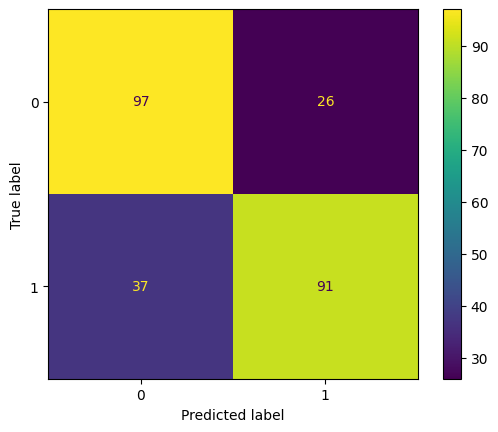

In [17]:
display_report(y_test, predictions)

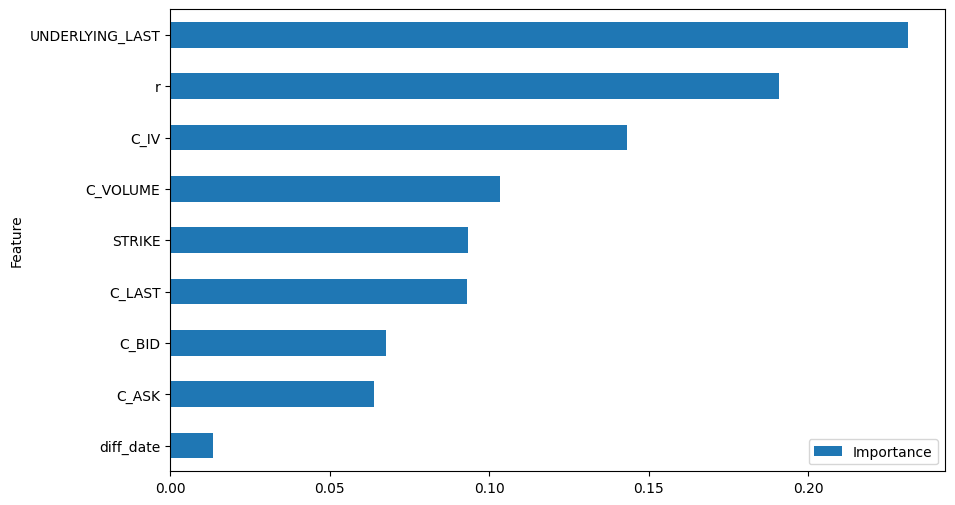

In [18]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [19]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_in"])

### Backtesting

In [20]:
strategy = []
date_idx = []
prev_price = 0.0
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = X_test.iloc[-i, :].to_dict()
    quote_date = X_test.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [21]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

strategy_df = strategy_df.sort_index()

In [22]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [23]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2018-02-05,0,265.0,8.22,2018-02-28,271.649994,0.000000,-1.570006,0.000000,-1.570006
2018-02-22,0,270.0,4.26,2018-03-14,275.299988,0.000000,1.039988,0.000000,-0.530018
2018-03-08,0,274.0,2.85,2018-03-29,263.149994,0.000000,-2.850000,0.000000,-3.380018
2018-03-09,0,279.0,2.47,2018-03-29,263.149994,0.000000,-2.470000,0.000000,-5.850018
2018-04-03,1,260.5,5.09,2018-04-23,266.570007,0.980007,0.980007,0.980007,-4.870011
...,...,...,...,...,...,...,...,...,...
2022-10-25,0,385.0,10.50,2022-11-14,395.119995,0.000000,-0.380005,509.679843,389.189830
2022-11-01,0,385.0,9.48,2022-11-21,394.589996,0.000000,0.109996,509.679843,389.299827
2022-11-02,1,375.0,10.19,2022-11-23,402.420013,17.230013,17.230013,526.909856,406.529840


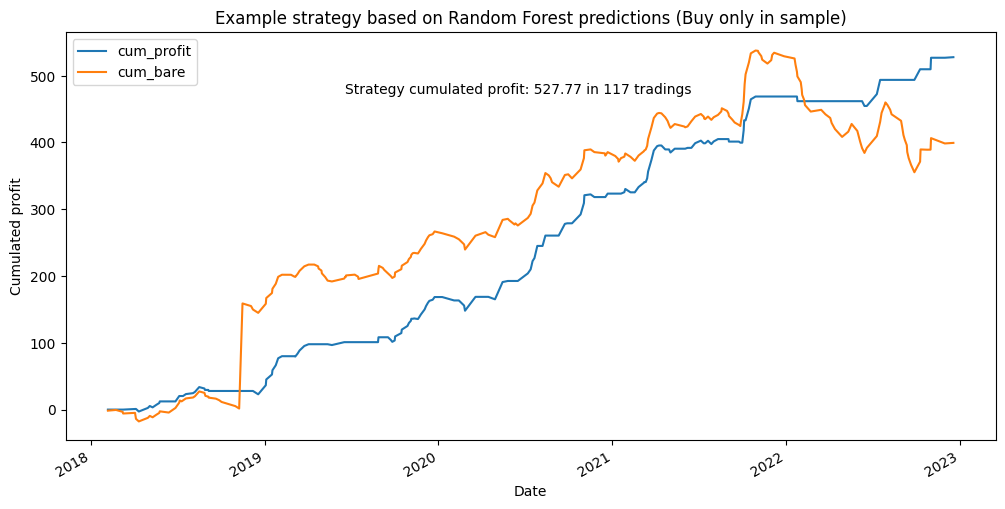

In [24]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on Random Forest predictions (Buy only in sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

### Out-of-sample predictions

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df.values,
    target.values.flatten(),
    test_size=0.2,
    random_state=1968,
    shuffle=False,
)

In [26]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", RandomForestClassifier(**params)),
    ]
)

In [27]:
# Fit the tuned model
pipe.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  97 out of  97 | elapsed:    0.4s finished


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_features=None,
                                        min_samples_leaf=2, n_estimators=97,
                                        n_jobs=4, random_state=1968,
                                        verbose=1))])

In [28]:
predictions = pipe.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  97 out of  97 | elapsed:    0.0s finished


In [29]:
pipe.score(X_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  97 out of  97 | elapsed:    0.1s finished


0.6135458167330677

              precision    recall  f1-score   support

           0       0.68      0.84      0.75       177
           1       0.15      0.07      0.09        74

    accuracy                           0.61       251
   macro avg       0.42      0.45      0.42       251
weighted avg       0.53      0.61      0.56       251



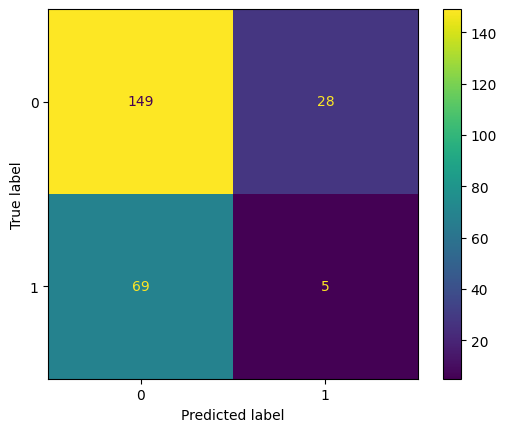

In [30]:
display_report(y_test, predictions)

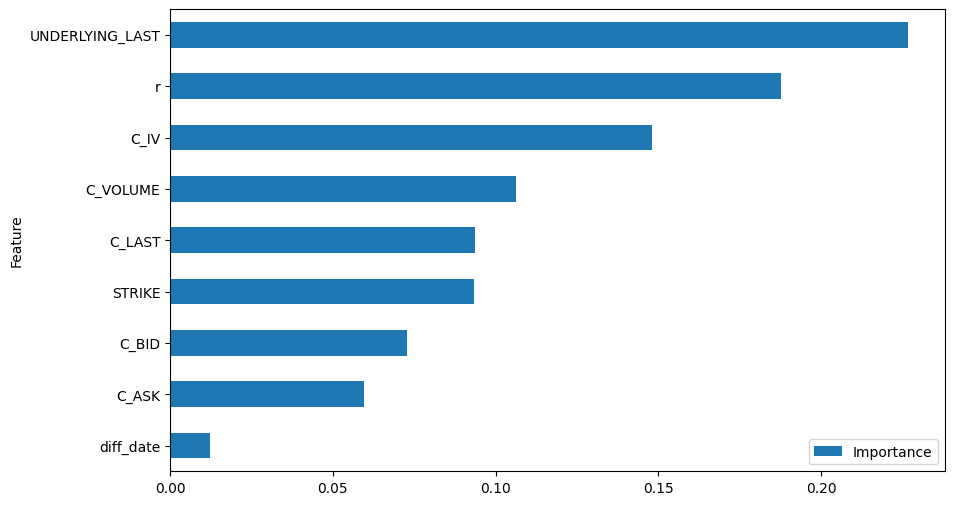

In [31]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [32]:
compare_df["bare_rf_pred_out"] = predictions

### Backtest strategy

In [33]:
strategy = []
date_idx = []
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = orig_df.iloc[-i, :].to_dict()
    quote_date = orig_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    final_price = spy.loc[exp_date, "Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [34]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

In [35]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [36]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-01-03,0,478.0,4.81,2022-01-24,439.839996,0.0,-4.810000,0.000000,-4.810000
2022-01-04,0,478.0,4.80,2022-01-24,439.839996,0.0,-4.800000,0.000000,-9.610000
2022-01-05,0,468.0,8.14,2022-01-26,433.380005,0.0,-8.140000,0.000000,-17.750000
2022-01-06,0,468.0,7.00,2022-01-26,433.380005,0.0,-7.000000,0.000000,-24.750000
2022-01-07,0,466.0,7.56,2022-01-28,441.950012,0.0,-7.560000,0.000000,-32.310000
...,...,...,...,...,...,...,...,...,...
2022-12-23,0,383.0,8.00,2023-01-13,398.500000,0.0,7.500000,-203.969994,-525.980022
2022-12-26,0,383.0,7.96,2023-01-13,398.500000,0.0,7.540000,-203.969994,-518.440022
2022-12-28,0,377.0,8.75,2023-01-20,395.880005,0.0,10.130005,-203.969994,-508.310017


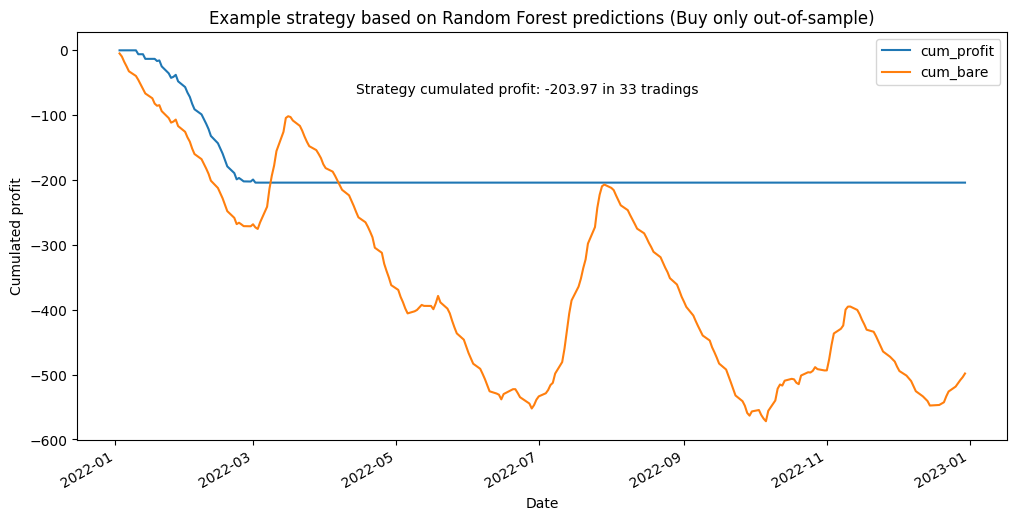

In [37]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on Random Forest predictions (Buy only out-of-sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

## Random Forest with data from MC simulation and additional features

In [38]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [39]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### In sample predictions

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=True
)

In [41]:
params = {
    "random_state": 1968,
    "n_estimators": 89,
    "min_samples_split": 10,
    "min_samples_leaf": 1,
    "max_features": "sqrt",
    "max_depth": 12,
    "criterion": "entropy",
    "bootstrap": False,
} | {"n_jobs": 4, "verbose": 1}

In [42]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", RandomForestClassifier(**params)),
    ]
)

In [43]:
# Fit the tuned model
pipe.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  89 out of  89 | elapsed:    0.3s finished


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_depth=12, min_samples_split=10,
                                        n_estimators=89, n_jobs=4,
                                        random_state=1968, verbose=1))])

In [44]:
predictions = pipe.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  89 out of  89 | elapsed:    0.0s finished


In [45]:
pipe.score(X_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  89 out of  89 | elapsed:    0.0s finished


0.7729083665338645

              precision    recall  f1-score   support

           0       0.77      0.76      0.77       123
           1       0.78      0.78      0.78       128

    accuracy                           0.77       251
   macro avg       0.77      0.77      0.77       251
weighted avg       0.77      0.77      0.77       251



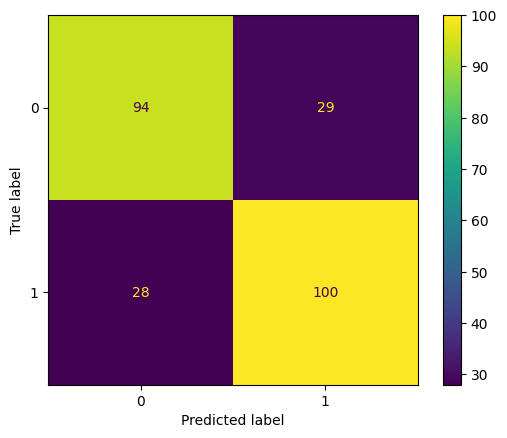

In [46]:
display_report(y_test, predictions)

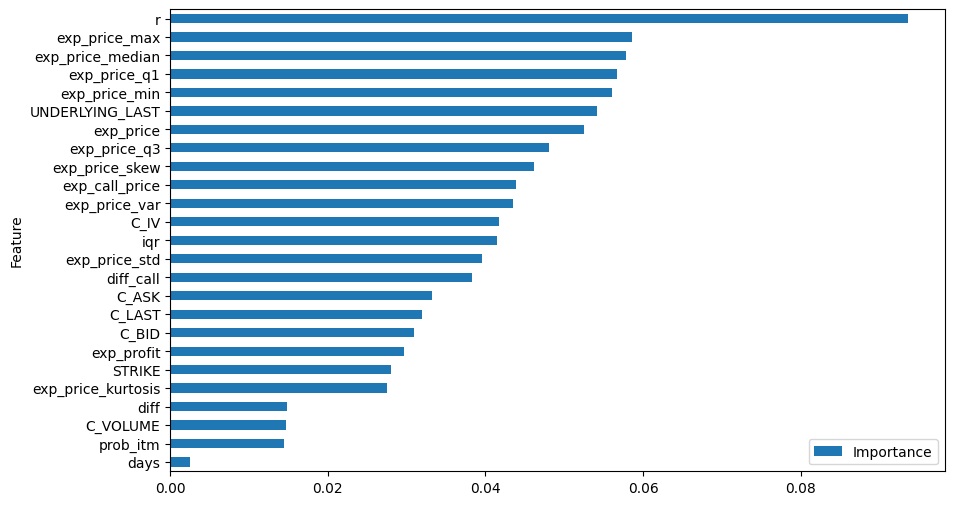

In [47]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [48]:
compare_df["mmar_rf_pred_in"] = predictions

### Backtesting

In [49]:
strategy = []
date_idx = []
prev_price = 0.0
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = X_test.iloc[-i, :].to_dict()
    quote_date = X_test.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [50]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

strategy_df = strategy_df.sort_index()

In [51]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [52]:
strategy_df

,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,,
2018-02-05,0,265.0,8.22,4.942161,2018-02-28,271.649994,0.000000,-1.570006,0.000000,-1.570006
2018-02-22,0,270.0,4.26,6.397086,2018-03-14,275.299988,0.000000,1.039988,0.000000,-0.530018
2018-03-08,0,274.0,2.85,5.917690,2018-03-29,263.149994,0.000000,-2.850000,0.000000,-3.380018
2018-03-09,0,279.0,2.47,5.505012,2018-03-29,263.149994,0.000000,-2.470000,0.000000,-5.850018
2018-04-03,1,260.5,5.09,5.247430,2018-04-23,266.570007,0.980007,0.980007,0.980007,-4.870011
...,...,...,...,...,...,...,...,...,...,...
2022-10-25,1,385.0,10.50,9.062317,2022-11-14,395.119995,-0.380005,-0.380005,554.049867,389.189830
2022-11-01,1,385.0,9.48,8.719475,2022-11-21,394.589996,0.109996,0.109996,554.159863,389.299827
2022-11-02,1,375.0,10.19,8.901524,2022-11-23,402.420013,17.230013,17.230013,571.389877,406.529840


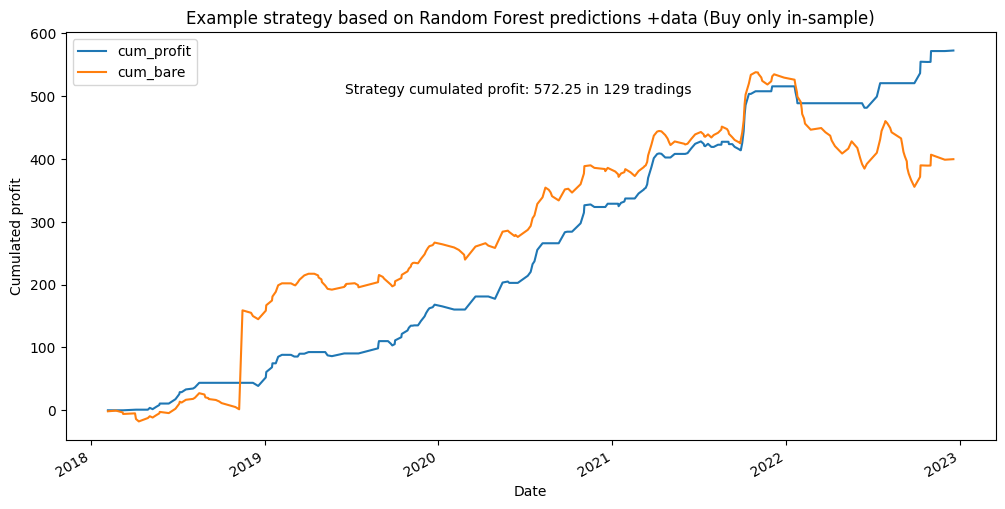

In [53]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on Random Forest predictions +data (Buy only in-sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

### Out-of-sample predictions

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df.values,
    target.values.flatten(),
    test_size=0.2,
    random_state=1968,
    shuffle=False,
)

In [55]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", RandomForestClassifier(**params)),
    ]
)

In [56]:
# Fit the tuned model
pipe.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  89 out of  89 | elapsed:    0.3s finished


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_depth=12, min_samples_split=10,
                                        n_estimators=89, n_jobs=4,
                                        random_state=1968, verbose=1))])

In [57]:
predictions = pipe.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  89 out of  89 | elapsed:    0.0s finished


In [58]:
pipe.score(X_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  89 out of  89 | elapsed:    0.0s finished


0.46613545816733065

              precision    recall  f1-score   support

           0       0.69      0.45      0.54       177
           1       0.28      0.51      0.36        74

    accuracy                           0.47       251
   macro avg       0.48      0.48      0.45       251
weighted avg       0.57      0.47      0.49       251



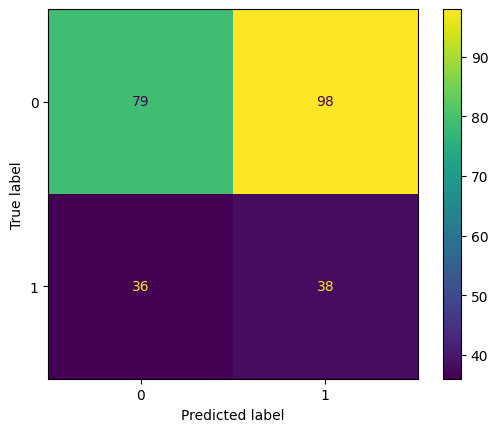

In [59]:
display_report(y_test, predictions)

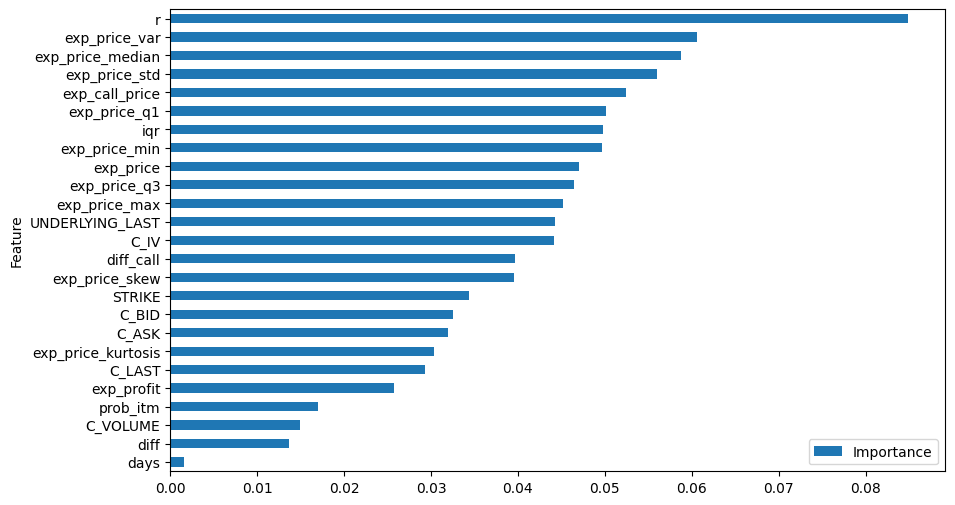

In [60]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [61]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtest strategy

In [62]:
strategy = []
date_idx = []
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = new_df.iloc[-i, :].to_dict()
    quote_date = new_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    final_price = spy.loc[exp_date, "Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [63]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

In [64]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [65]:
strategy_df

,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,,
2022-01-03,0,478.0,4.81,10.248337,2022-01-24,439.839996,0.000000,-4.810000,0.000000,-4.810000
2022-01-04,0,478.0,4.80,9.610177,2022-01-24,439.839996,0.000000,-4.800000,0.000000,-9.610000
2022-01-05,1,468.0,8.14,10.191128,2022-01-26,433.380005,-8.140000,-8.140000,-8.140000,-17.750000
2022-01-06,1,468.0,7.00,9.657596,2022-01-26,433.380005,-7.000000,-7.000000,-15.140000,-24.750000
2022-01-07,1,466.0,7.56,9.927762,2022-01-28,441.950012,-7.560000,-7.560000,-22.700000,-32.310000
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0,383.0,8.00,8.453400,2023-01-13,398.500000,0.000000,7.500000,-385.500010,-525.980022
2022-12-26,1,383.0,7.96,8.096501,2023-01-13,398.500000,7.540000,7.540000,-377.960010,-518.440022
2022-12-28,1,377.0,8.75,8.526141,2023-01-20,395.880005,10.130005,10.130005,-367.830005,-508.310017


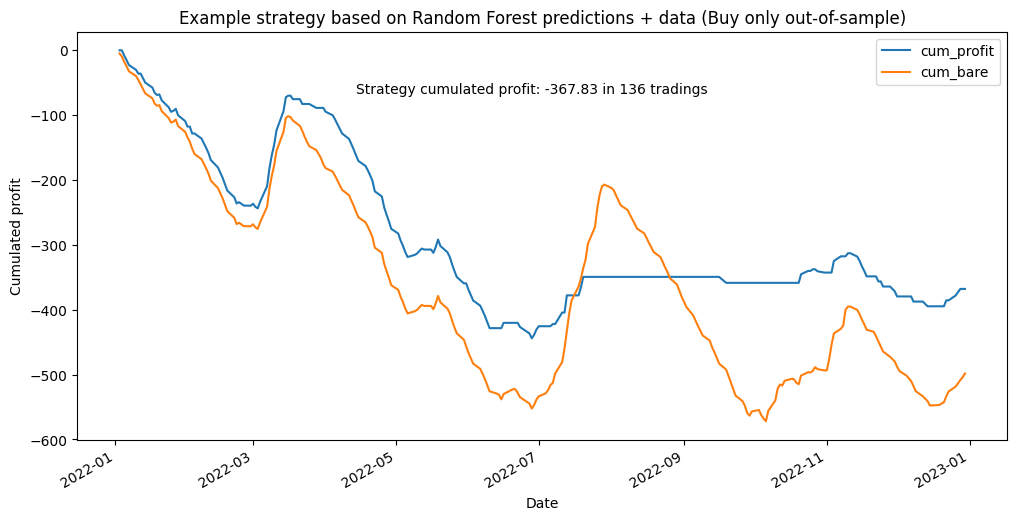

In [66]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on Random Forest predictions + data (Buy only out-of-sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

## Compare the two predictions

In [67]:
mask_in = (compare_df["bare_rf_pred_in"] - compare_df["mmar_rf_pred_in"]).astype(bool)
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [68]:
# Compare in sample preds
compare_df[mask_in]

,bare_rf_pred_in,bare_rf_pred_out,mmar_rf_pred_in,mmar_rf_pred_out
0,0,0,1,0
1,1,0,0,0
21,1,1,0,1
23,1,1,0,1
36,0,1,1,1
39,1,1,0,1
40,0,1,1,1
46,0,0,1,1
50,0,0,1,1
63,0,0,1,0


In [69]:
compare_df[mask_in].shape

(48, 4)

In [70]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_in,bare_rf_pred_out,mmar_rf_pred_in,mmar_rf_pred_out
2,0,0,0,1
3,1,0,1,1
4,1,0,1,1
5,0,0,0,1
8,0,0,0,1
...,...,...,...,...
238,1,0,1,1
241,1,0,1,1
245,0,0,0,1
247,0,0,1,1


In [71]:
compare_df[mask_out].shape

(107, 4)

In [72]:
compare_df.sum(axis=0)

bare_rf_pred_in     117
bare_rf_pred_out     33
mmar_rf_pred_in     129
mmar_rf_pred_out    136
dtype: int64